## Lesson 4: Email Assistant with Semantic + Episodic Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings
- Uses memory to remember details from previous emails 

Now, we'll add human-in-the-loop following the triage step to better refine the assistant's ability to classify emails.

In [ ]:
%%capture stderr
%pip install -e ..
%pip install -U -q langchain-anthropic langgraph langchain langmem==0.0.5rc9

In [1]:
import os
from getpass import getpass

if not os.environ.get("ANTHROPIC_API_KEY"):
    os.environ["ANTHROPIC_API_KEY"] = getpass("ANTHROPIC_API_KEY: ")

### Define Triage

The triage step is the "first line of defense" against incoming emails. It helps the assistant determine if the email should be responded to, ignored, or notified.

In [1]:
from memory_course.schemas import Router
from langchain.chat_models import init_chat_model
from memory_course.prompts import triage_system_prompt, triage_user_prompt

llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

# We'll use structured output to generate classification results
llm_router = llm.with_structured_output(Router)


### Define Tools

Define tools that the agent can use. These are place-holder tools for the purpose of testing the LLM.

In [2]:
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"


@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Define Store

In [3]:
# Example user profile
example_user_profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
}

In [5]:
from langgraph.store.memory import InMemoryStore

# Memory store
store = InMemoryStore()

# Save user profile
user = "lance"
namespace = ("email_assistant", user, "user_profile")
key = "user_profile"
store.put(namespace, key, example_user_profile)

## Define agent

In [7]:
# Create agent
from memory_course.prompts import agent_system_prompt_semantic
from langmem import create_manage_memory_tool, create_search_memory_tool
from langgraph.prebuilt import create_react_agent

# Get profile
profile = store.get(namespace, key)

# Format profile
profile_data = profile.value
format_data = {
    **profile_data, # Include all individual fields (name, full_name, etc)
    'profile': str(profile_data) # Add the full profile as a string
}

# Create agent
response_agent = create_react_agent(
    "anthropic:claude-3-5-sonnet-latest",
    tools=[write_email, schedule_meeting, 
           check_calendar_availability, 
           create_manage_memory_tool(namespace=("email_assistant", user, "collection")),
           create_manage_memory_tool(namespace=("email_assistant", user, "user_profile")),
           create_search_memory_tool(namespace=("email_assistant", user, "collection"))
           ],
    prompt=agent_system_prompt_semantic.format(**format_data),
)

### Build agent + triage workflow

Combine triage with tool calling agent



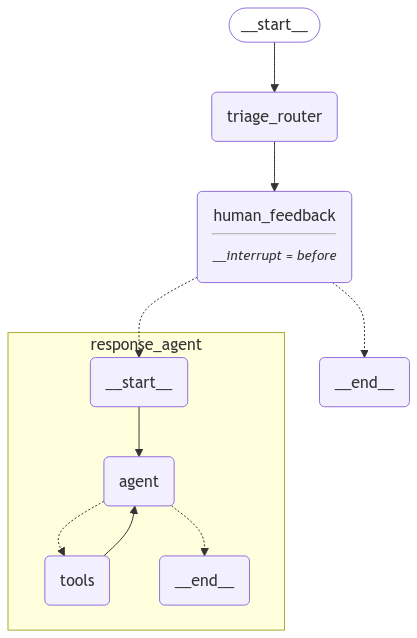

In [14]:
import uuid
from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display
from memory_course.schemas import State
from memory_course.utils import parse_email

def human_feedback(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """ No-op node that should be interrupted on """

    # Check if human feedback is different from routing decision
    if state.get("human_feedback") and state["human_feedback"] != state["routing_decision"]:

        # Save example
        user = "lance" # TODO: from config 
        namespace = ("email_assistant", user, "examples")
        key = f"example_{uuid.uuid4()}"
        example = f"""Email: {state['email_input']}
            Original routing: {state['routing_decision']}
            Correct routing: {state['human_feedback']}"""
        store.put(namespace, key, example)

        # Set routing decision to correct value
        state['routing_decision'] = state['human_feedback']

    # Route
    goto = "__end__"
    update = None
    if state['routing_decision'] == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ],
        }
    elif state['routing_decision'] == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

    elif state['routing_decision'] == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
    else:
        raise ValueError(f"Invalid classification: {state['routing_decision']}")

    return Command(goto=goto, update=update)

def triage_router(state: State, store: BaseStore) -> Command["human_feedback"]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    author, to, subject, email_thread = parse_email(state["email_input"])
    
    # Get profile from store
    profile = store.get(namespace, key)
    profile_data = profile.value

    # Set examples
    user = "lance" # TODO: from config 
    namespace = ("email_assistant", user, "examples")
    examples = store.search(namespace) # TODO: Format these 

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        full_name=profile_data["full_name"],
        name=profile_data["name"],
        user_profile_background=profile_data["user_profile_background"],
        triage_no=profile_data["triage_rules"]["ignore"],
        triage_notify=profile_data["triage_rules"]["notify"],
        triage_email=profile_data["triage_rules"]["respond"],
        examples=examples,
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    
    # Get feedback
    return Command(goto="human_feedback", update={"routing_decision" : result.classification})

# Build workflow with store, as defined above
agent = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", response_agent)
    .add_node("human_feedback", human_feedback)
    .add_edge(START, "triage_router")
    .add_edge("triage_router", "human_feedback")
    .compile(store=store, interrupt_before=["human_feedback"])
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))